In [1]:
import snowflake.connector
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
conn = snowflake.connector.connect(user='RAPPIONE_USER',
                password='xW&&v5alPUx4FW@7XjX&67Jb',
                account='hg51401',
                warehouse='NORMAL_LOAD',
                database='FIVETRAN',
                schema='REVENUE_DATASCIENCE',
                role='REVENUE_DATASCIENCE_WRITE_ROLE'                   
                )

In [3]:
Pais = 'BR'
City = 'Juiz de Fora'
Inicio = '2021-01-16'
Final = '2021-04-15'
lngmin = -46
lngmax = -45
latmin = -23
latmax = 0

In [4]:
HVU = '''
WITH
  base AS (
  SELECT *
  FROM REVENUE_DATASCIENCE.ORDERS_DENORMALIZED_{}_CPG_MDM
  WHERE (city) LIKE '{}'
  AND DATE(created_at) BETWEEN '{}' AND '{}'
  ),
  orders_base AS (
  SELECT 
    User_id,order_id,
    TO_DATE(created_at) AS DateOrder,
    CAST(total_price AS FLOAT) AS total_price
  FROM base ),
  rfm_base AS (
  SELECT
    user_id,
    DATEDIFF(DAY, MAX(DateOrder) ,'{}') AS recency,
    CASE 
      WHEN COUNT(DISTINCT order_id) = 1 THEN 0
    ELSE COUNT(DISTINCT order_id) END AS frecuency,
    ROUND(SUM(total_price) / COUNT(DISTINCT order_id), 2) AS monetary
  FROM
    orders_base
  GROUP BY
    user_id   
    ),
  rfm_recency as(
  Select 
  PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY recency) as RP_25,
  PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY recency) as RP_50,
  PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY recency) as RP_75
  From rfm_base
  ), 
  rfm_frecuency as(
  Select 
  PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY frecuency) as FP_25,
  PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY frecuency) as FP_50,
  PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY Frecuency) as FP_75
  From rfm_base
  where frecuency <> 0
  ),
  rfm_monetary as(
  Select 
  PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY monetary) as MP_25,
  PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY monetary) as MP_50,
  PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY monetary) as MP_75
  From rfm_base
  ), rfm_score as (
Select *,
CASE
        WHEN recency <= rp_25 THEN '4'
        WHEN recency <= rp_50 THEN '3'
        WHEN recency <= rp_75 THEN '2'
        WHEN recency > rp_75 THEN '1'
    END
      AS R,
       CASE
        WHEN frecuency = 0 THEN '0'
        WHEN frecuency <= fp_25 THEN '1'
        WHEN frecuency <= fp_50 THEN '2'
        WHEN frecuency <= fp_75 THEN '3'
        WHEN frecuency > fp_75 THEN '4'
    END
      AS F,
      CASE
        WHEN monetary <= mp_25 THEN '1'
        WHEN monetary <= mp_50 THEN '2'
        WHEN monetary <= mp_75 THEN '3'
        WHEN monetary > fp_75 THEN '4'
    END
      AS M
From rfm_base
left Join rfm_recency on 1=1
left Join rfm_frecuency on 1=1
left Join rfm_monetary on 1=1
), ccord as (
SELECT User_id,user_lat,user_lng,city,
       count(distinct order_id) as Orders,
       row_number() over (partition by User_id order by count(distinct order_id) desc) as rn
  FROM base
  GROUP BY 1,2,3,4
), 
Csales as (
SELECT User_id, Sum(total_Price) as Ventas_CPG
  FROM base
  where lower(mdm_vertical_name) like '%cpg%' 
  GROUP BY 1
),Fsales as (
SELECT User_id, Sum(total_Price) as Ventas_Full
  FROM base
GROUP BY 1
), 
fullusers as (
Select User_id, CONCAT(R,F,M) AS RFM, user_lat, user_lng, city 
From RFM_score s
Left Join ccord using(user_id)
where rn = 1
), Final as (
Select *,
Case
WHEN RFM IN ('444','443', '442', '344', '343', '244') THEN 'HVU'
ELSE 'OTHERS' END AS Type,
Case when ventas_cpg is null then null else user_id end as User_CPG 
From fullusers
Left JOin Csales using(user_Id)
Left JOin Fsales using(user_Id)
WHERE USER_LAT IS NOT NULL AND USER_LNG IS NOT NULL 
-- and USER_LNG BETWEEN '{}' AND '{}'
-- and USER_LAT BETWEEN '{}' AND '{}'
)
Select *
From Final
order by 1
 '''
cur = conn.cursor()
cur.execute(HVU.format(Pais,City,Inicio,Final,Final,lngmin,lngmax,latmin,latmax))
HVU = cur.fetch_pandas_all()
HVU

,USER_ID,RFM,USER_LAT,USER_LNG,CITY,VENTAS_CPG,VENTAS_FULL,TYPE,USER_CPG
0,3043693,422,-21.767724,-43.348913,Juiz de Fora,127.89,127.89,OTHERS,3.043693e+06
1,3430928,211,-21.773445,-43.344147,Juiz de Fora,None,55.40,OTHERS,NaN
2,3490525,411,-21.770538,-43.381918,Juiz de Fora,None,41.70,OTHERS,NaN
3,3526711,302,-21.765347,-43.345733,Juiz de Fora,None,51.80,OTHERS,NaN
4,3613366,304,-21.766846,-43.349428,Juiz de Fora,171.80,171.80,OTHERS,3.613366e+06
...,...,...,...,...,...,...,...,...,...
7486,3922156309,404,-21.780125,-43.334962,Juiz de Fora,794.54,794.54,OTHERS,3.922156e+09
7487,3922156931,402,-21.757543,-43.351437,Juiz de Fora,41.04,41.04,OTHERS,3.922157e+09
7488,3922160610,404,-21.779047,-43.355695,Juiz de Fora,118.37,118.37,OTHERS,3.922161e+09
7489,3922207834,402,-21.780705,-43.361894,Juiz de Fora,51.09,51.09,OTHERS,3.922208e+09


In [5]:
HVU = HVU.sort_values(['VENTAS_CPG','USER_ID'], ascending=False)
HVU = HVU.reset_index(drop=True)
HVU

,USER_ID,RFM,USER_LAT,USER_LNG,CITY,VENTAS_CPG,VENTAS_FULL,TYPE,USER_CPG
0,3715281139,444,-21.764445,-43.376460,Juiz de Fora,13182.55,13727.28,HVU,3.715281e+09
1,3616517734,444,-21.774440,-43.352889,Juiz de Fora,9261.08,9261.08,HVU,3.616518e+09
2,3113970752,444,-21.767986,-43.348732,Juiz de Fora,8804.34,8804.34,HVU,3.113971e+09
3,3014999196,444,-21.759643,-43.356809,Juiz de Fora,8214.03,8214.03,HVU,3.014999e+09
4,3420484415,444,-21.781598,-43.344229,Juiz de Fora,7626.27,7779.11,HVU,3.420484e+09
...,...,...,...,...,...,...,...,...,...
7486,30381182,103,-21.761686,-43.349723,Juiz de Fora,None,54.90,OTHERS,NaN
7487,30192363,431,-21.770080,-43.335876,Juiz de Fora,None,134.49,OTHERS,NaN
7488,3526711,302,-21.765347,-43.345733,Juiz de Fora,None,51.80,OTHERS,NaN
7489,3490525,411,-21.770538,-43.381918,Juiz de Fora,None,41.70,OTHERS,NaN


In [6]:
USERS = HVU.groupby(['TYPE']).agg({'USER_ID':lambda x: x.nunique(),'USER_CPG':lambda x: x.nunique(),'VENTAS_FULL': ['sum'],'VENTAS_CPG': ['sum']})
USERS.columns = ['USERS','USERS_CPG','SALES','CPG_SALES']
USERS.to_excel("Darks_Polania_Full_"+Pais+"_"+City+".xlsx")  

In [7]:
from googleapiclient.discovery import build
from google.oauth2 import service_account

SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SERVICE_ACCOUNT_FILE = 'user.json'

credentials = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)

# The ID and range of a sample spreadsheet.
SAMPLE_SPREADSHEET_ID = '1ZEX3htRmB5doCu0dntih00av97h0-eOQjYkm0_MzO_E'
SAMPLE_RANGE_NAME ="Base!A1:E200"
service = build('sheets', 'v4', credentials=credentials)
    # Call the Sheets API
sheet = service.spreadsheets()
result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
values = result.get('values', [])
stores = pd.DataFrame(values)
new_header = stores.iloc[0] #grab the first row for the header
stores = stores[1:] #take the data less the header row
stores.columns = new_header #set the header row as the df header
stores = stores[(stores['Ciudad'] == City)]
stores['Lat'] = stores['Lat'].astype(float)
stores['Lng'] = stores['Lng'].astype(float)
stores = stores.iloc[: , 1:]
stores = stores.iloc[:, :-1]
stores

,Direccion,Lat,Lng


In [8]:
HVU['key'] = 0
stores['key'] = 0
Geoloc = pd.merge(HVU, stores, on='key')
Geoloc

,USER_ID,RFM,USER_LAT,USER_LNG,CITY,VENTAS_CPG,VENTAS_FULL,TYPE,USER_CPG,key,Direccion,Lat,Lng


In [9]:
Geoloc['DISTANCE'] = 123387 * pow((pow((Geoloc['USER_LAT']-Geoloc['Lat']),2) + pow((Geoloc['USER_LNG']-Geoloc['Lng']),2)),0.5)
Geoloc = Geoloc.query("DISTANCE < 2000")
Geoloc

,USER_ID,RFM,USER_LAT,USER_LNG,CITY,VENTAS_CPG,VENTAS_FULL,TYPE,USER_CPG,key,Direccion,Lat,Lng,DISTANCE


In [10]:
bodega_cercana = Geoloc.groupby('USER_ID').agg(min_ = ('DISTANCE', lambda data: data.idxmin()))
bodega_cercana['min_'] = bodega_cercana['min_'].apply(np.int64) 
col_one_list = bodega_cercana['min_'].tolist()
Geoloc = Geoloc.loc[col_one_list]
Geoloc

,USER_ID,RFM,USER_LAT,USER_LNG,CITY,VENTAS_CPG,VENTAS_FULL,TYPE,USER_CPG,key,Direccion,Lat,Lng,DISTANCE


In [11]:
grouped_multiple = Geoloc.groupby(['Direccion','Lat','Lng','TYPE']).agg({'USER_ID':lambda x: x.nunique(),'USER_CPG':lambda x: x.nunique(),'VENTAS_FULL': ['sum'],'VENTAS_CPG': ['sum']})
grouped_multiple.columns = ['USERS','USERS_CPG','SALES','CPG_SALES']
grouped_multiple 

,USERS,USERS_CPG,SALES,CPG_SALES


In [12]:
grouped_multiple.to_excel("Darks_Polania_Prev_All"+Pais+"_"+City+".xlsx")  

In [13]:
HVU2 = pd.merge(HVU,Geoloc, how='left',left_on=['USER_ID'],right_on=['USER_ID'],indicator=True, suffixes=('', '_XY'))
HVU2 = HVU2.query('_merge == "left_only"')
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('_XY')]]
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('_merge')]]
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('DISTANCE')]]
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('key')]]
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('Cidade')]]
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('Address')]]
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('Lat')]]
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('Lng')]]
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('Name')]]
HVU2 = HVU2[HVU2.columns[~HVU2.columns.str.endswith('Status')]]
HVU2

,USER_ID,RFM,USER_LAT,USER_LNG,CITY,VENTAS_CPG,VENTAS_FULL,TYPE,USER_CPG,Direccion
0,3715281139,444,-21.764445,-43.376460,Juiz de Fora,13182.55,13727.28,HVU,3.715281e+09,NaN
1,3616517734,444,-21.774440,-43.352889,Juiz de Fora,9261.08,9261.08,HVU,3.616518e+09,NaN
2,3113970752,444,-21.767986,-43.348732,Juiz de Fora,8804.34,8804.34,HVU,3.113971e+09,NaN
3,3014999196,444,-21.759643,-43.356809,Juiz de Fora,8214.03,8214.03,HVU,3.014999e+09,NaN
4,3420484415,444,-21.781598,-43.344229,Juiz de Fora,7626.27,7779.11,HVU,3.420484e+09,NaN
...,...,...,...,...,...,...,...,...,...,...
7486,30381182,103,-21.761686,-43.349723,Juiz de Fora,None,54.90,OTHERS,NaN,NaN
7487,30192363,431,-21.770080,-43.335876,Juiz de Fora,None,134.49,OTHERS,NaN,NaN
7488,3526711,302,-21.765347,-43.345733,Juiz de Fora,None,51.80,OTHERS,NaN,NaN
7489,3490525,411,-21.770538,-43.381918,Juiz de Fora,None,41.70,OTHERS,NaN,NaN


In [14]:
X = np.array(HVU2[["USER_LAT","USER_LNG"]])
y = np.array(HVU2['USER_ID'])
X.shape

(7491, 2)

# PRE

In [15]:
Kluster = 2
kmeans = KMeans(n_clusters=Kluster).fit(X)
centroids = kmeans.cluster_centers_

In [16]:
darks = pd.DataFrame(centroids, columns = ['DS_LAT','DS_LNG'])
darks['DS'] = City+'_'+darks.index.astype(str)
darks

,DS_LAT,DS_LNG,DS
0,-21.749140,-43.353889,Juiz de Fora_0
1,-21.774972,-43.352421,Juiz de Fora_1


In [17]:
HVU2['key'] = 0
darks['key'] = 0
Geoloc2 = pd.merge(HVU2, darks, on='key')

In [18]:
Geoloc2['DISTANCE'] = 123387 * pow((pow((Geoloc2['USER_LAT']-Geoloc2['DS_LAT']),2) + pow((Geoloc2['USER_LNG']-Geoloc2['DS_LNG']),2)),0.5)
Geoloc2 = Geoloc2.query("DISTANCE < 2000")

In [19]:
bodega_cercana2 = Geoloc2.groupby('USER_ID').agg(min_ = ('DISTANCE', lambda data: data.idxmin()))
bodega_cercana2['min_'] = bodega_cercana2['min_'].apply(np.int64) 
col_one_list2 = bodega_cercana2['min_'].tolist()
Geoloc2 = Geoloc2.loc[col_one_list2]
Geoloc2

,USER_ID,RFM,USER_LAT,USER_LNG,CITY,VENTAS_CPG,VENTAS_FULL,TYPE,USER_CPG,Direccion,key,DS_LAT,DS_LNG,DS,DISTANCE
3939,3043693,422,-21.767724,-43.348913,Juiz de Fora,127.89,127.89,OTHERS,3.043693e+06,NaN,0,-21.774972,-43.352421,Juiz de Fora_1,993.578318
14981,3430928,211,-21.773445,-43.344147,Juiz de Fora,None,55.40,OTHERS,NaN,NaN,0,-21.774972,-43.352421,Juiz de Fora_1,1038.147668
14977,3526711,302,-21.765347,-43.345733,Juiz de Fora,None,51.80,OTHERS,NaN,NaN,0,-21.774972,-43.352421,Juiz de Fora_1,1446.143169
3195,3613366,304,-21.766846,-43.349428,Juiz de Fora,171.80,171.80,OTHERS,3.613366e+06,NaN,0,-21.774972,-43.352421,Juiz de Fora_1,1068.556035
1429,3626246,114,-21.766794,-43.347707,Juiz de Fora,435.64,435.64,OTHERS,3.626246e+06,NaN,0,-21.774972,-43.352421,Juiz de Fora_1,1164.673334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9916,3922125626,401,-21.740387,-43.358899,Juiz de Fora,None,15.90,OTHERS,NaN,NaN,0,-21.749140,-43.353889,Juiz de Fora_0,1244.474154
7554,3922156931,402,-21.757543,-43.351437,Juiz de Fora,41.04,41.04,OTHERS,3.922157e+09,NaN,0,-21.749140,-43.353889,Juiz de Fora_0,1080.062949
4141,3922160610,404,-21.779047,-43.355695,Juiz de Fora,118.37,118.37,OTHERS,3.922161e+09,NaN,0,-21.774972,-43.352421,Juiz de Fora_1,644.973859
6843,3922207834,402,-21.780705,-43.361894,Juiz de Fora,51.09,51.09,OTHERS,3.922208e+09,NaN,0,-21.774972,-43.352421,Juiz de Fora_1,1366.123771


In [20]:
grouped_multiple2 = Geoloc2.groupby(['DS','DS_LAT','DS_LNG','TYPE']).agg({'USER_ID':lambda x: x.nunique(),'USER_CPG':lambda x: x.nunique(),'VENTAS_FULL': ['sum'],'VENTAS_CPG': ['sum']})
grouped_multiple2.columns = ['USERS','USERS_CPG','SALES','CPG_SALES']
grouped_multiple2

USERS  USERS_CPG      SALES  \
DS             DS_LAT     DS_LNG     TYPE                                  
Juiz de Fora_0 -21.749140 -43.353889 HVU       158      157.0  224992.95   
                                     OTHERS   1820     1099.0  214191.96   
Juiz de Fora_1 -21.774972 -43.352421 HVU       355      348.0  516731.79   
                                     OTHERS   3224     2134.0  400917.78   

                                             CPG_SALES  
DS             DS_LAT     DS_LNG     TYPE               
Juiz de Fora_0 -21.749140 -43.353889 HVU     207103.08  
                                     OTHERS  153642.70  
Juiz de Fora_1 -21.774972 -43.352421 HVU     469146.53  
                                     OTHERS  289342.48

In [21]:
Coverage = grouped_multiple2['USERS'].sum()
Total = HVU2['USER_ID'].count()
Index2 = (Coverage / Total) *100
print(Index2)

74.18235215592044


In [22]:
#viables = grouped_multiple2.query('SALES >= 65000000')
grouped_multiple2

USERS  USERS_CPG      SALES  \
DS             DS_LAT     DS_LNG     TYPE                                  
Juiz de Fora_0 -21.749140 -43.353889 HVU       158      157.0  224992.95   
                                     OTHERS   1820     1099.0  214191.96   
Juiz de Fora_1 -21.774972 -43.352421 HVU       355      348.0  516731.79   
                                     OTHERS   3224     2134.0  400917.78   

                                             CPG_SALES  
DS             DS_LAT     DS_LNG     TYPE               
Juiz de Fora_0 -21.749140 -43.353889 HVU     207103.08  
                                     OTHERS  153642.70  
Juiz de Fora_1 -21.774972 -43.352421 HVU     469146.53  
                                     OTHERS  289342.48

C:\Users\Usuario\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


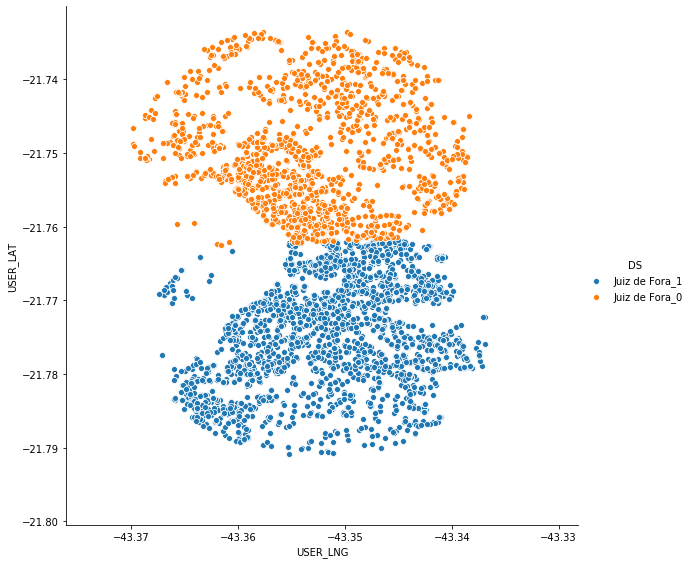

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(x_vars=['USER_LNG'], y_vars=['USER_LAT'], data=Geoloc2, hue="DS", size=8)

In [24]:
grouped_multiple2 .to_excel("Darks_Polania3_"+Pais+"_"+City+"_All.xlsx")  